In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


%matplotlib inline

from reco.matching import get_highest_energy_fraction_simtracksters
from reco.energy import get_total_energy
from reco.plotting import plot_event, plot_remapped
from reco.evaluation import evaluate, evaluate_remapped
from reco.features import longest_path_from_highest_centrality, mean_edge_length, mean_edge_energy_gap
from reco.graph_utils import create_graph

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 78, tracksters sim: 10
Precision: 0.97, Recall: 0.29, F-score: 0.45
Simulated energy: 3522.02, reconstructed energy: 3123.60 (88.69%)


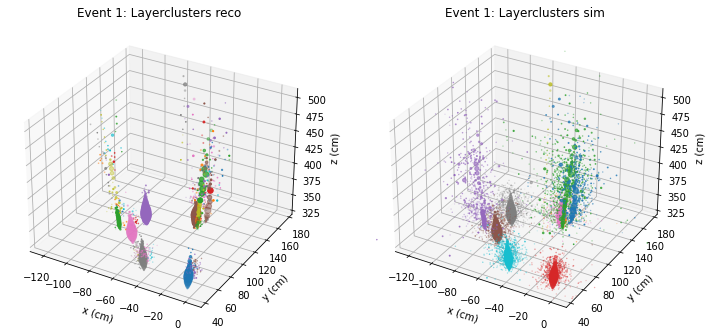

In [17]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [18]:
x_bary = tracksters["barycenter_x"].array()[eid]
y_bary = tracksters["barycenter_y"].array()[eid]
z_bary = tracksters["barycenter_z"].array()[eid]
X = np.array([x_bary, y_bary, z_bary]).T

Sanity check

In [19]:
# use the barycentres as seeds
seeds = X
kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X)

evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_)

Precision: 0.97, Recall: 0.06, F-score: 0.11


## Extract features

Starting simple with trackster energy

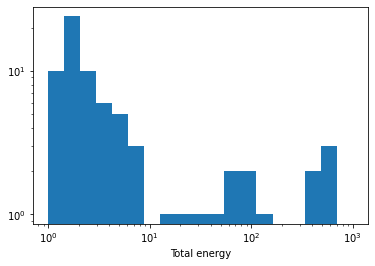

In [20]:
tre = [sum(e) for e in t_energy]

fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(111)
ax.set_xlabel("Total energy")
ax.hist(tre, bins=10**np.linspace(0, 3, 20))
ax.set_yscale("log")
ax.set_xscale("log")

plt.show()

Tracksters reco: 11, tracksters sim: 10
Precision: 0.92, Recall: 0.65, F-score: 0.76


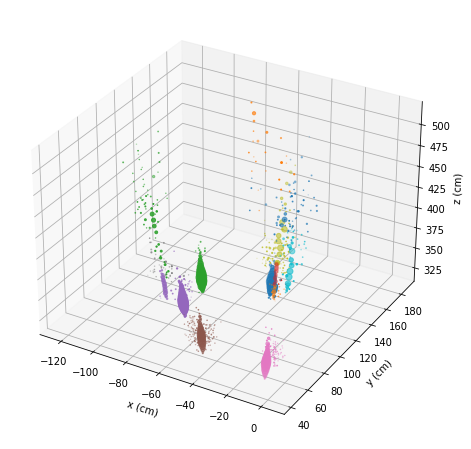

In [31]:
# only select higher energy tracksters
seeds = X[np.array(tre) > 20]
kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X)

print(f"Tracksters reco: {max(kmeans.labels_)-1}, tracksters sim: {len(st_indexes)}")

evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_, noise=False)
plot_remapped(tracksters, eid, kmeans.labels_)

## Combine features with PCA

Use the component covering the greatest variance from PCA.

In [45]:
features = []

cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()

def extract_features(_eid):
    for x, y, z, e in zip(cx[_eid], cy[_eid], cz[_eid], ce[_eid]):
        G = create_graph(x, y, z, e, N=1)
        yield (
            sum(e),
            len(e),
            longest_path_from_highest_centrality(G),
            mean_edge_length(G),
            mean_edge_energy_gap(G)
        )

# extract features from a larger dataset
for _eid in range(len(cx)):
    features += extract_features(_eid)

scaler = StandardScaler()
feat = np.array(features)
feat_s = scaler.fit_transform(feat)

# fit PCA on all data
pca = PCA(n_components=1).fit(feat_s)

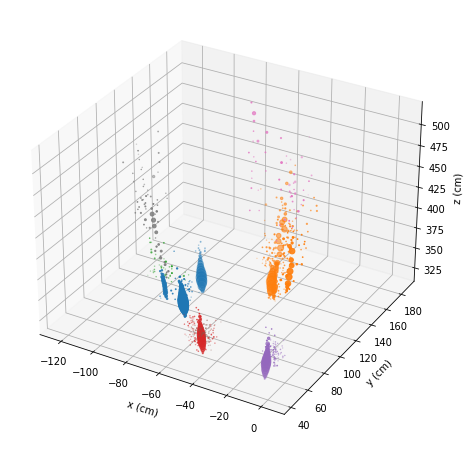

Tracksters reco: 6, tracksters sim: 10
Precision: 0.74, Recall: 0.74, F-score: 0.74


In [47]:
# compute and standardize the event features
event_data = scaler.transform(list(extract_features(eid)))

# transform the event features
data = pca.transform(event_data)

seeds = X[data[:,0] > 2]
kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X)
plot_remapped(tracksters, eid, kmeans.labels_)

print(f"Tracksters reco: {max(kmeans.labels_)-1}, tracksters sim: {len(st_indexes)}")
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_, noise=False)